# Ordinary Kriging

Kriging is an advancde geostatistical method that generates a perediction of surface from a scattered set of points. Unlike IDW which is purely based on surrounding measured values, the Kriging method uses statistical models to better account for spatial autocorrelation. Kriging can be thought of as a two step process in which first the rule of dependecy is uncovered (variogram), and second the prediction is made based on the knowledge of spatial correlation of data as assessed in the first step.

In [1]:
inLibraries = list('repr','rgdal','gstat','spdep','rgeos','geoR','sp','RColorBrewer','classInt','MASS','forecast')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

Warning message:
“no DISPLAY variable so Tk is not available”

## Read Observed Measurements

In this practice, the primary goal is to obtain a good estimate of maximum temperature for locations in Missouri. While observations of temperature from locations solely within the state could be used, it is much better to also include observations from surrounding states as well in order to avoid edge effects. As such, we will use observations of maximum temperature at 245 weather stations over the state of Missouri and its eight surroundings states (KY,AR,IA,IL,KS,NE,OK,TN) to infer maximum temperature at locations having no weather station.

The station point locations can be found at (weatherdata/weatherdatapoints.shp) and state boundaries that can be used for spatial context can be found at (weatherdata/states_polygon.shp). The maximum temperature attribute in the station dataset is named 'highTemp' and was derived from a single day's weather information obtained from https://www.wunderground.com/.

In [2]:
# Read point data of weather station locations
inFeature.pts <- readOGR("/dsa/data/geospatial/DS8612/weatherdata","weatherdatapoints")

# Read polygon data of states boundaries
inFeature.polys <- readOGR("/dsa/data/geospatial/DS8612/weatherdata","states_polygon")

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/weatherdata", layer: "weatherdatapoints"
with 230 features
It has 17 fields
OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/weatherdata", layer: "states_polygon"
with 9 features
It has 9 fields


In [3]:
head(inFeature.pts@data)

state,city,day,month,year,period,highTemp,lowTemp,conditions,qpf_allday,snow_allda,avewindSpe,avewindDir,avewindDeg,avehumidit,Longi,Lati
IA,Chariton,13,7,2017,1,82,61,Partly Cloudy,0,0,0,West,272,81,-93.31,41.01
OK,Chickasha,13,7,2017,1,100,73,Clear,0,0,0,SSW,211,69,-97.95,35.04
IL,Lacon,13,7,2017,1,84,62,Partly Cloudy,0,0,4,West,0,89,-89.41,41.02
IA,Clarion,13,7,2017,1,77,55,Partly Cloudy,0,0,7,NNW,0,86,-93.73,42.72
AR,De Queen,13,7,2017,1,98,73,Partly Cloudy,0,0,1,SW,224,92,-94.34,34.04
TN,Memphis,13,7,2017,1,92,75,Partly Cloudy,0,0,5,SSW,204,81,-90.05,35.15


In [4]:
head(inFeature.polys@data)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER
0,20,00481813,0400000US20,20,KS,Kansas,00,211753253104,1346235678
1,29,01779791,0400000US29,29,MO,Missouri,00,178052653610,2487575477
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177663722167,3373836066
3,05,00068085,0400000US05,05,AR,Arkansas,00,134771517596,2960191698
4,17,01779784,0400000US17,17,IL,Illinois,00,143788697679,6206693598
5,19,01779785,0400000US19,19,IA,Iowa,00,144667643793,1077808017


## Sync CRS of Point and Polygon Featureclasses

If you look at the two input datasets, you'll find that they are in two different CRSs. As such, if we wish to compare or overlay these geographies, then they will need to be in the same CRS. The point data are in UTM zone 15N...let's use that CRS. Now, convert the polygon featureclass into the same CRS as the point featureclass.

In [9]:
#Get CRS of the point featureclass
ptCRS <- proj4string (inFeature.pts)

# Transform to angular system (lat/long)
inFeature.polys.UTM <- spTransform(inFeature.polys, CRS(ptCRS))

In [10]:
proj4string(inFeature.polys)

[1] "+proj=longlat +datum=NAD83 +no_defs +ellps=GRS80 +towgs84=0,0,0"

In [7]:
ptCRS

[1] "+proj=utm +zone=15 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0"

In [8]:
proj4string(inFeature.polys.UTM)

[1] "+proj=utm +zone=15 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0"

## Refining the Sampling Region

It should be noted that states in the U.S. can cover considerable geographic extents and climatic conditions. Thus, including all weather stations in surrounding states could introduce weather patterns that are not fully representative of the region of interest. In other words, there could be outlier weather conditions in the dataset given that only a subset of the stations in the world are being sampled. As such, it may be better to only include stations within some reasonable range of the state vs all stations in surrounding states.

To do this: 

a) select the Missouri polygon, 

b) buffer the polygon by some distance (needs to be in the same crs as the data - meters in this case, 

c) find the stations that intersect the buffered area.  

In this example, buffer the state by 200 miles, which is approximately 321,869 meters.

In [11]:
#Select State = Missouri
selPoly <- inFeature.polys.UTM[inFeature.polys.UTM@data$NAME == 'Missouri', ]

#Compute the geometric dialation of the selected feature
bufferDistance <- 321869

selPoly.Buf <- gBuffer(selPoly, 
                           byid = TRUE, 
                           id = NULL, 
                           width = bufferDistance, 
                           quadsegs = 5, 
                           capStyle = "ROUND", 
                           joinStyle = "ROUND", 
                           mitreLimit = 1.0)

#compute geometric intersection
interPoints <- overGeomGeom(selPoly.Buf, 
                                inFeature.pts, 
                                returnList = TRUE, 
                                fn = NULL)

#subset intersecting points
intSet <- unlist(interPoints)
Regional.pts <- inFeature.pts[intSet, ]

# Define new variable for interpolation
inVa <- as.numeric(Regional.pts$highTemp)

## Visualize the Selected Data Points

Classify the observed data values of the selected points and plot the points to examine the spatial distribution of the selected data.

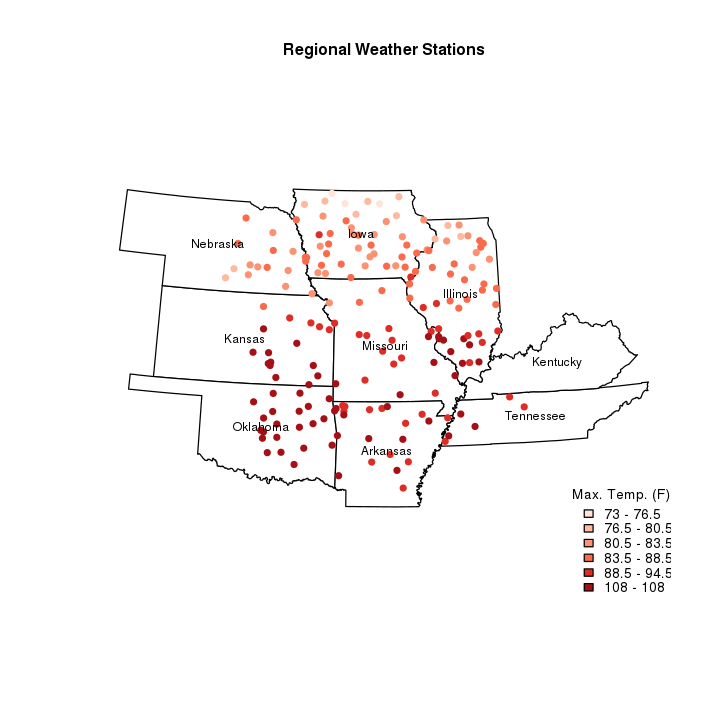

In [14]:
#Configure classification parameters
numcat <- 6
repeattimes <- 25
cate <- classIntervals(inVa, numcat, style = "kmeans", rtimes = repeattimes)

#assign colors to categories
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate, pal)

# Map input data
plot(inFeature.polys.UTM, col = "white", main = "Regional Weather Stations", cex.main = 0.8)

plot(Regional.pts, col = cols, pch = 20, add = TRUE)

# Get centroid of polygons
centroids <- gCentroid(inFeature.polys.UTM, byid = TRUE)

centroidLons <- coordinates(centroids)[,1]

centroidLats <- coordinates(centroids)[,2]

# Label the name of polygons
text(centroidLons, centroidLats, labels = inFeature.polys.UTM$NAME, cex = 0.6)

#map classification scheme
decimalPlaces <- 3

brks.dec <- round(cate$brks, decimalPlaces)

leg.text <- paste(brks.dec[-numcat], brks.dec[-1], sep = " - ")

legend("bottomright", 
           fill = attr(cols, "palette"),
           legend = leg.text,
           bty = "n",
           title = "Max. Temp. (F)",
           cex = 0.7)

## Assess Normality

One assumption of the kriging interpolation technique is that the data are normally distributed. There are several ways to check normality of data. In this case, first examine the distribution and qq plot and then apply the Shapiro-Wilk normality test. 

As can be seen, the density plot is not bell shaped and is skewed. The same could be implied by looking at qq plot which considerably deviates from the line and the theoretical normal distribution. The null hypothesis (data is normally distributed) is rejected at 1% significance level (0.00% < 1.00%) according to the Shapiro-wilk test.

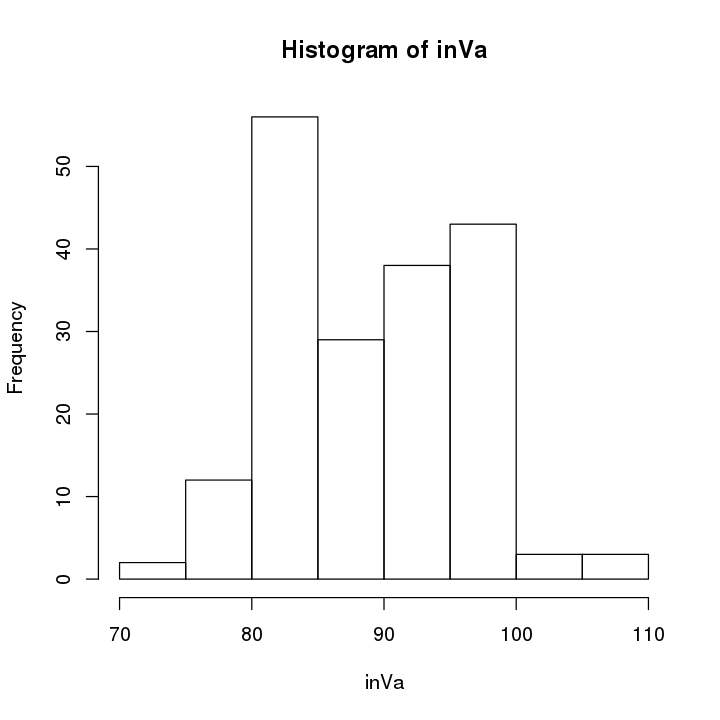


	Shapiro-Wilk normality test

data:  inVa
W = 0.9621, p-value = 6.497e-05


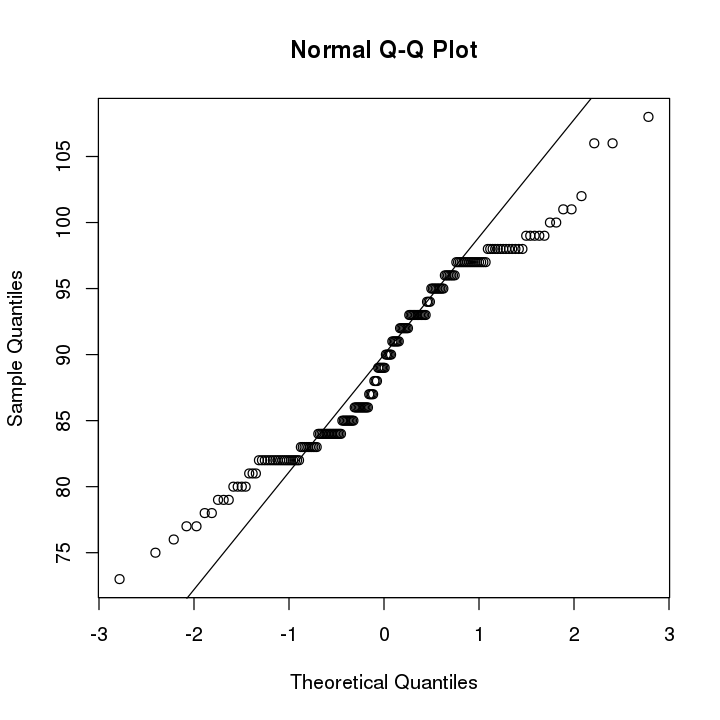

In [61]:
# plot the density function
hist(inVa)

# Draw the qq plot
qqnorm(inVa)

# fit the line
qqline(inVa)

# conduct sahpiro test
shapiro.test(inVa)

## Transform Data

Though, the data as is does not meet normality assumption of Kriging method, the distribution appears to be somewhat normal. Remember, we should keep in mind that this dataset is only a small portion of the weather stations in the U.S. and as such, the choice of the stations to analyze here could impact the characteristics of the distribution. 

However, there are a variety of transformations that can be applied to help improve the distributional characteristics of the data. In this example, a Box-Cox transformation is applied.  

First, the BoxCox.lambda() function (forecast library) is used to estimate the transformation parameter. 

Second, the BoxCox() function (forecast library) is used to actually apply the Box-Cox transformation. 

One reason for using this function is that later on, we will need to backtransform the transformed values and the forecast library provides an easy function for accomplishing this.  

The Box-Cox transformation seems to improve the characteristics of the data, but the test for normality are still poor. 

However, let's still apply the method, but keep in mind that the accuracy of the prediction could be affected.

Can you think of a better way to either transform the data or to remove problematic data to improve the normality of the dataset? If so, post it to the discussion page!

In [15]:
#box-cox transformation
lambda <- BoxCox.lambda(inVa, method = "guerrero", lower = -4, upper = 4) 
lambda


[1] 0.4429748

In [19]:
#apply box cox transformation to variable
tva <- BoxCox(inVa, lambda)

tva[1:5]

[1] 13.64236 13.81299 13.20536 14.94870 14.47383

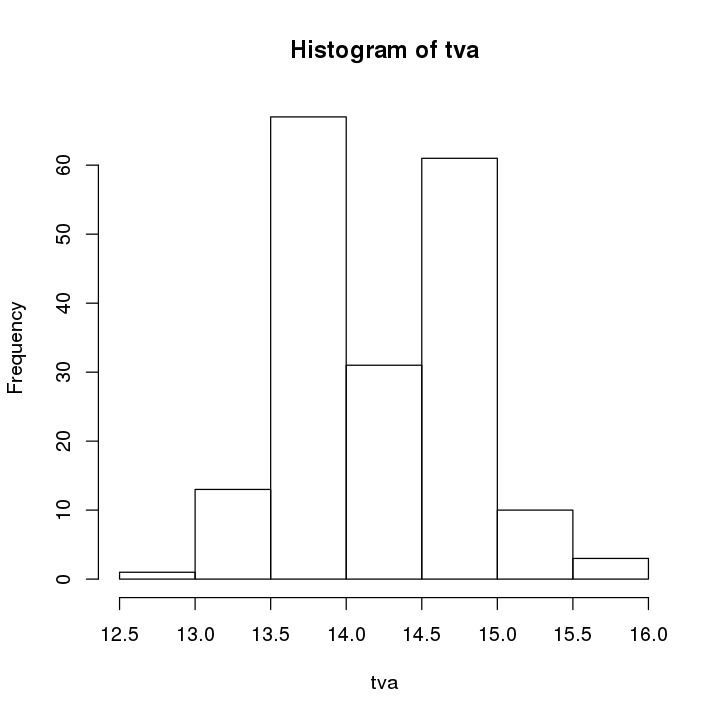

In [20]:
#test transformed variable
hist(tva)

In [21]:
shapiro.test(tva)


	Shapiro-Wilk normality test

data:  tva
W = 0.9631, p-value = 8.309e-05


## Create an Interpolation Grid Dataframe

In order to interpolate something, a areal unit that represents the area for which a value will be interpolated is needed. Most often, interpolation techniques use raster cells as the areal unit of interpolation.  The krige() function (gstat library) requires an input grid dataframe to which to interpolate the point values. In order to create a grid that covers the study area, the extent of data should be specified. Also, the grid projection needs to be the same as input data.

In [23]:
coordinates(inFeature.pts)[1:5, ]

coords.x1,coords.x2
473932.65,4539913
48331.81,3888698
801860.58,4547188
440229.03,4729980
376308.03,3767401


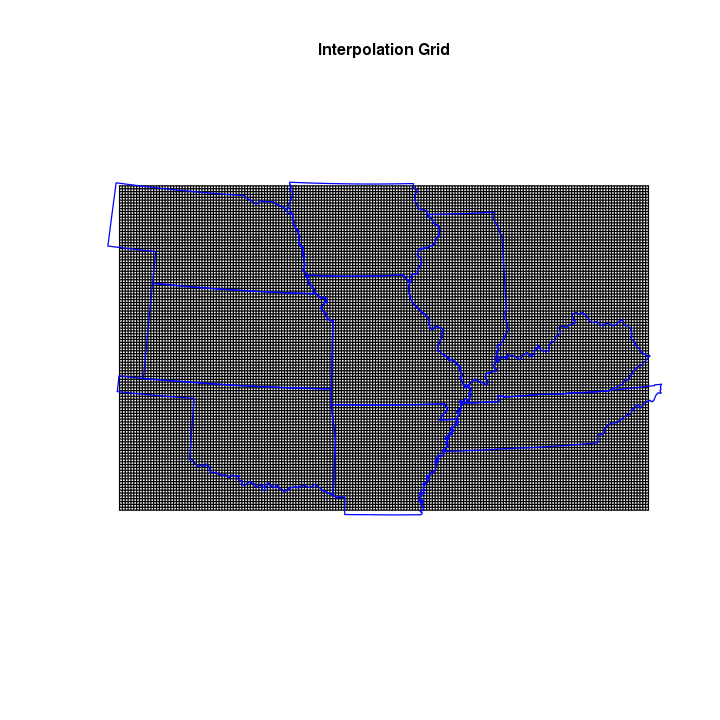

In [25]:
# create a grid object using extent of study site, lower values of cell size gives better resolution but higher computation time
cellsize <- 10000
grd <- expand.grid(Longitude = seq(
                                    from = min (coordinates(inFeature.pts)[,1]), 
                                    to = max (coordinates(inFeature.pts)[,1]), 
                                    by = cellsize),
                   Latitude = seq(
                                   from = min (coordinates(inFeature.pts)[,2]),
                                   to = max (coordinates(inFeature.pts)[,2]), 
                                   by = cellsize))

# specify the coordination system of grid object to be that of original dataset
coordinates(grd) <- ~Longitude + Latitude

# condition grid object
gridded(grd) <- TRUE

# set the projection system to be that of original dataset
proj4string(grd) <- proj4string(Regional.pts)

# visualize the grid object 
plot (grd, main = "Interpolation Grid", cex.main = 0.8)
plot(inFeature.polys.UTM, border = 'blue', add = TRUE)

## Fit Variogram to Sample Observations

Here, a mathematical model is fitted to the empirical variogram. The empirical variogram is calculated using variogram() function (gstat package). The distances considered in the computation of the empirical variogram can be limited by the 'cutoff' parameter. 

Once the empirical variogram is computed, the fit.variogram() function is used to fit a theoretical model to the sample. 

The key parameters to fit.variogram function are a sample variogram (output of variogram function) and variogram model (output of vgm() function). 

The vgm() function allows the variogram characteristics (sill, range, nugget and model form (i.e. Exp, Gau, Sph, etc.) to be adjusted to improve the fit. 

The choice of which model form to use (i.e. Exp, Gau, Sph) depends on how one believes the covariance function decreases as distances between points increase. 

Let's explore a few model forms.

### Exponential Model

In the exponential model, the covariance function decreases exponentially as distance between the points increases. Here, the cutoff in the empirical variogram is set to 100,000m, the sill is set to 7.5, a range = 40,000 m. Experiment with other model parameterizations (cutoff, sill, range, nugget) to examine how the fitted curve in plot changes and/or if a valid variogram exists for other parameterizations.

In [26]:
# Create empirical variogram
vrg <- variogram(as.numeric (tva) ~ 1, Regional.pts, cutoff = 100000)

# Fit a mathematical model (exponential) to the empirical variogram
fit.vrg.exp <- fit.variogram(vrg, vgm(psill = 7.5, "Exp", range = 40000, nugget = 0))

# view the estimated variogram parameters
fit.vrg.exp

model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
Nug,0.00000000,0.00,0.0,0,0,0,1,1
Exp,0.05776495,29381.91,0.5,0,0,0,1,1


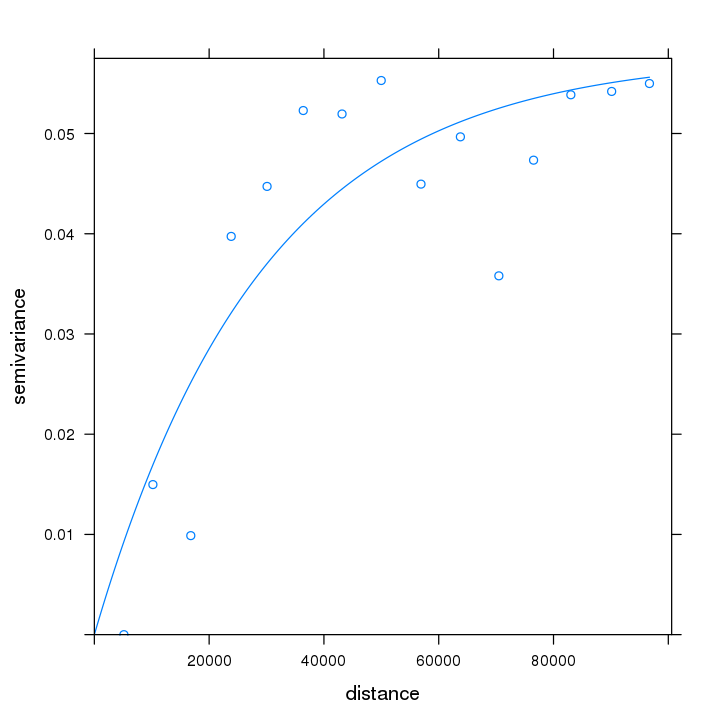

In [27]:
# Plot fitted variogram
plot(vrg, fit.vrg.exp)

## Kriging - Exponential Model

Once the variogram is fitted to the sample, the krige() (gstat library) can be used to conduct ordinary Kriging as below. The Kriging method gives prediction values and their variance as measure of accuracy. 

Remember that earlier the observed temperature values were transformed to help improve normality. However, those transformed values are less intuitive to interpret. Therefore, to better visualize the predicted values, a backtransformation needs to be applied. 

Here, the InvBoxCox() function (forecast library) is applied to do the backtransformation given that the BoxCox transformation was applied earlier. 

Note, in order to classify the predicted values using classIntervals(), they are first converted into a vector, then backtransformed. Then a new attribute is added to the spatialpixel dataframe to store the backtransformed variable.

As can be seen from the second plot below, the estimation variance increases towards the edges since less observations are used for prediction on periphery of study area.

In [28]:
# Implement ordinary Kriging and make the prediction for the exponential form
ok.exp <- krige(tva ~ 1, Regional.pts, grd, fit.vrg.exp)

#retrieve the interpolated files from the gridded spatialpixels dataframe
rvals <- ok.exp@data$var1.pred

#backtransform predicted values
btrvals <- InvBoxCox(ok.exp@data$var1.pred, lambda)
ok.exp@data$btvar1.pred <- InvBoxCox(ok.exp@data$var1.pred, lambda)

[using ordinary kriging]


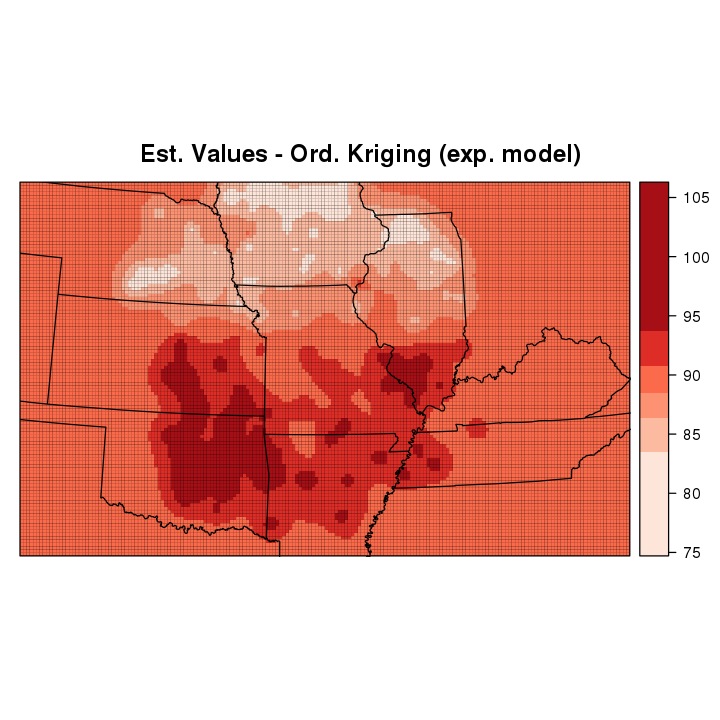

In [31]:
#classify the predicted data values and assign a color schema
numcat <- 6
cate <- classIntervals(btrvals, numcat, style = "kmeans")
color.pal <- brewer.pal(numcat, "Reds")

# Plot the Kriging estimation
spplot(ok.exp["btvar1.pred"], 
               col.regions = color.pal,
               main = "Est. Values - Ord. Kriging (exp. model)",
               at = cate$brks, cex.main = 0.8, 
               panel = function(...) {
                           panel.gridplot(..., border = "black")
                           sp.polygons(inFeature.polys.UTM)
               })


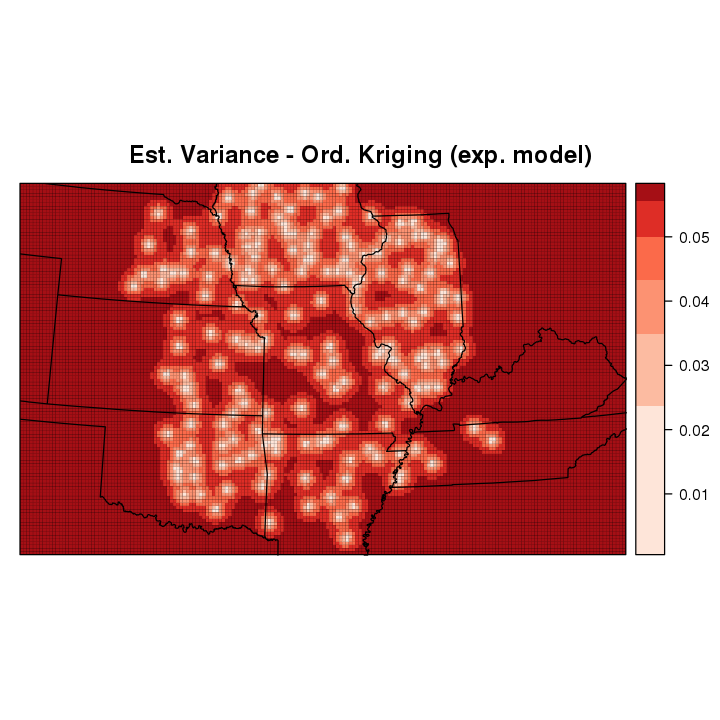

In [32]:
#retrieve the variance from the gridded spatialpixels dataframe
varvals <- ok.exp@data$var1.var

#classify the variance and assign a color schema
numcat <- 6
cate2 <- classIntervals(varvals, numcat, style = "kmeans")
color.pal2 <- brewer.pal(numcat, "Reds")

# Plot the variance of estimation
spplot(ok.exp["var1.var"], col.regions = color.pal2, at = cate2$brks, 
             main = "Est. Variance - Ord. Kriging (exp. model)",
             cex.main=.8, 
             panel = function(...) {
                     panel.gridplot(..., border="black")
                     sp.polygons(inFeature.polys.UTM)
             })

### Spherical Model

In the spherical model, the covariance function decreases constantly with increasing distance between points. Here, the cutoff in the empirical variogram is set to 100,000m, the sill is set to 7.5, a range=40,000m and an Sph model form. Experiment with other model parameterizations (cutoff, sill, range, nugget) to examine how the fitted curve in plot changes.

model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
Nug,0.00000000,0.00,0.0,0,0,0,1,1
Sph,0.05040729,49648.33,0.5,0,0,0,1,1


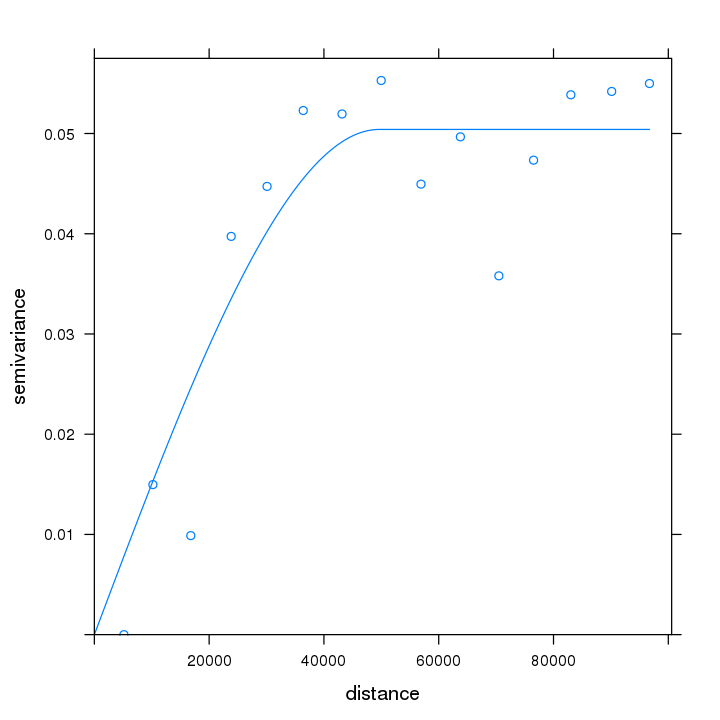

In [33]:
# Create empirical variogram
vrg <- variogram(as.numeric (tva) ~ 1, Regional.pts,cutoff=100000)

# Fit a mathematical model (exponential) to the empirical variogram
fit.vrg.sph <- fit.variogram(vrg, vgm(psill=7.5, "Sph", range=40000, nugget=0))

# view the estimated variogram parameters
fit.vrg.sph

# Plot fitted variogram
plot(vrg,fit.vrg.sph)

## Implement Kriging for spherical form

[using ordinary kriging]


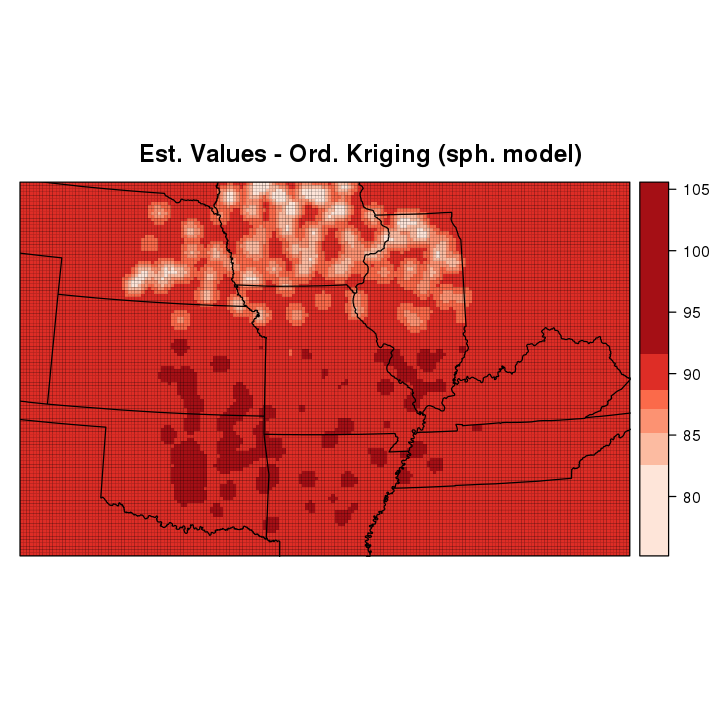

In [35]:
# Implement ordinary Kriging using the sherical variogram
ok.sph <- krige(tva ~ 1, Regional.pts, grd, fit.vrg.sph)

#retrieve the interpolated files from the gridded spatialpixels dataframe
rvals <- ok.sph@data$var1.pred

#backtransform predicted values
btrvals <- InvBoxCox(ok.sph@data$var1.pred, lambda)
ok.sph@data$btvar1.pred <- InvBoxCox(ok.sph@data$var1.pred, lambda)

#classify the predicted data values and assign a color schema
numcat <- 6
cate <- classIntervals(btrvals, numcat, style = "kmeans")
color.pal <- brewer.pal(numcat, "Reds")

# Plot the Kriging estimation
spplot(ok.sph["btvar1.pred"], 
               col.regions = color.pal,
               main = "Est. Values - Ord. Kriging (sph. model)",
               at = cate$brks, cex.main = 0.8, 
               panel = function(...) {
                     panel.gridplot(..., border="black")
                     sp.polygons(inFeature.polys.UTM)
               })

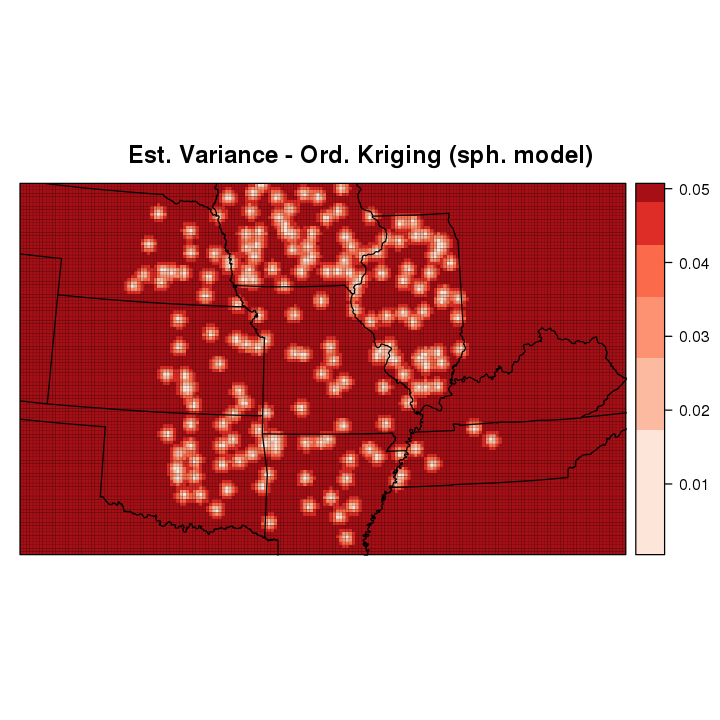

In [36]:
#retrieve the variance from the gridded spatialpixels dataframe
varvals <- ok.sph@data$var1.var

#classify the variance and assign a color schema
numcat <- 6
cate2 <- classIntervals(varvals, numcat, style = "kmeans")
color.pal2 <- brewer.pal(numcat, "Reds")

# Plot the variance of estimation
spplot(ok.sph["var1.var"], 
       col.regions = color.pal2, 
       at = cate2$brks, 
       main = "Est. Variance - Ord. Kriging (sph. model)", cex.main = 0.8, 
       panel = function(...) {
             panel.gridplot(..., border="black")
             sp.polygons(inFeature.polys.UTM)
       })